# 使用信号处理函数-argrelextrema

In [ ]:
import numpy as np
from alpha.notebook import *
from scipy.signal import argrelextrema
import numpy as np
pd.options.display.max_rows = 999
from alpha.core.rsi_stats import rsi30, rsiday
import talib

await init_notebook()

shday = await get_bars("000001.XSHG", 100, '1d', '2021-11-5 15:00')
shmin = await get_bars("000001.XSHG", 220, '30m', '2021-11-05 15:00')

In [ ]:
def peak_and_valley(bars):
    ma = moving_average(bars["close"], 10)
    
    peak_indexes = argrelextrema(ma, np.greater)
    peaks = peak_indexes[0]

    # Find valleys(min).
    valley_indexes = argrelextrema(ma, np.less)
    valleys = valley_indexes[0]

    assert abs(len(peaks) - len(valleys)) <= 1
    
    bars = bars[9:]
    # Plot main graph.
    (fig, ax) = plt.subplots()
    ax.plot(np.arange(len(bars)), bars["close"], color='c')
    ax.plot(np.arange(len(bars)), ma, color='b')

    # Plot peaks.
    peak_x = peaks
    peak_y = bars['close'][peak_x]
    ax.plot(peak_x, peak_y, 'gv', label="Peaks")

    # Plot valleys.
    valley_x = valleys
    valley_y = bars['close'][valley_x]
    ax.plot(valley_x, valley_y, 'r^', label="Valleys")
     
    trades = []
    gains = 1
    order = None

    vertex = sorted([*peaks, *valleys])
    for x in vertex:
        close = bars["close"]
        buy = x in valleys
        sell = x in peaks
        if buy and order is None:
            order = {
                "buy": close[x] * 0.5 + close[x+1] * 0.5,
                "buy_at": bars["frame"][x+1]
            }

        elif sell and order:
            buy = order["buy"]
            sell = close[x+1] * 0.5 + close[x] * 0.5,
            gain = sell / buy
            order.update({
                "sell": sell,
                "sell_at": bars["frame"][x+1],
                "gain": gain
            })

            gains *= gain
            trades.append(order)
            order = None

    return gains - 1, trades

# 指数30分钟拐头报警

In [ ]:
minclose = shmin["close"]
minframe = shmin["frame"]
ma = moving_average(minclose, 5)

# align frame with ma
close = close[4:]
frame = frame[4:]
bars = sh[4:]


local_ma = argrelextrema(ma, np.greater, order=5)[0]
local_mi = argrelextrema(ma, np.less, order=5)[0]

plt.plot(ma)
plt.plot(local_ma, ma[local_ma], 'gv')
plt.plot(local_mi, ma[local_mi], 'r^')
for i in local_ma:
    plt.text(i, ma[i], f"{str(frame[i])[5:13]}_{i}")    
for i in local_mi:
    plt.text(i, ma[i], f"{str(frame[i])[5:13]}_{i}")

# 抛物线转向

股票的均线形态常常会出现类似于抛物线的向下、向下转向，尤其以指数为甚。但研究表明，抛物线拟合中容易出现错误信号。准确率不高，看如何提升？

如果连续几个周期出现a一致，而dist每次加1，则说明这个pattern比较稳定。

In [ ]:
def parabolic_features(ts, rng=7, ma_win=5, calc_ma=True):
    """检测`ts`代表的最后7个周期的均线中，是否存在抛物线特征。
    """
    if calc_ma:
        ts = moving_average(ts, ma_win)

    ts_ = ts[-rng:]
    (a, b, c), pmae = polyfit(ts_)

    # predict till next frame
    y_ = np.polyval((a,b,c), np.arange(rng + 1))

    # uncomment this to draw the lines
    # plt.plot(np.arange(len(ts)-rng, len(ts)), y_)
    # plt.plot(ts)

    vx = round(-b/(2*a),1)
    
    next_ts = reverse_moving_average(y_, rng, ma_win)
    pred_roc = next_ts/ts[-1] - 1
    
    return np.sign(pred_roc), pred_roc, rng - vx, round(a, 4), round(pmae, 5)

In [ ]:
for i in range(-10, -1):
    print(minframe[i], parabolic_features(minclose[:i]))

In [ ]:


def double_bottom(bars, win=10, gap=1e-3):
    """在`n`个周期里，是否存在两个底部


    Args:
        bars ([type]): [description]
        win (int, optional): [description]. Defaults to 10.

    Returns:
        [type]: [description]
    """
    low = bars["low"][-win:]
    pos = top_n_argpos(-low, 2)

    l1, l2 = low[pos]
    return abs(l1/l2 - 1) < gap

double_bottom(shday)

# 综合判断

目标： 需要能判断

33 10-25 10:00 底

10-26 10:30 顶 RSI

10-29 10:00 底 RSI

11-02 10:00 顶 抛物线转向？要求11：00能发出信号

11-03 13:30 底

11-03 14:30 底 RSI底背离

11-04 15:00 顶 抛物线转向？

In [ ]:
def reversal_features(code, bars, frame_type:FrameType, ma=None, wr_win=60, peak_altitude=1e-2):
    # 顺序
    # 0. WR
    # 1. RSI
    # 2. parabolic flip
    # 3. stock pattern
    # 4. local maximum/minimum
    
    assert frame_type in [FrameType.DAY, FrameType.MIN30]
    features = []

    open_, high, low, close = bars["open"], bars["high"], bars["low"], bars["close"]

    hh = np.max(high[-wr_win:])
    ll = np.min(low[-wr_win:])
    
    if ma is None:
        ma = moving_average(bars["close"], 5)
        
        bars = bars[4:]
    
    # wr
    wr = (hh - close[-1])/(hh - ll)
    
    features.append(wr)
        
    # rsi and prsi
    rsi = relative_strength_index(close, period=6)[-3:]
    
    rsistats = rsi30 if frame_type == FrameType.MIN30 else rsiday
    prsi = [rsistats.get_proba(code, v) for v in rsi]
    
    features.extend(prsi)
    features.extend(rsi)
    
    # parabolic features
    features.extend(parabolic_features(close))
    
    # stock pattern
    # double bottom | hammer | invert_hammer| long down shadow | long up shadow | double top | darkcloud cover 
    db = double_bottom(bars)
    _, shadow = hammer(bars[-1])
    
    if len(shadow):
        hm = shadow[0]
    else:
        hm = 0
    _, shadow = inverted_hammer(bars[-1])
    
    if len(shadow):
        ihm = shadow[0]
    else:
        ihm = 0
        
    ds = down_shadow(bars[-1])
    us = up_shadow(bars[-1])
    
    dt = double_top(bars)
    
    dcc = dark_cloud_cover(bars[-2:])
    dcc = False if dcc is None else True
    
    # local maximum/minimum
    n = 10
    peaks, valleys = peaks_and_valleys(close[-n:], min_altitude_ratio=peak_altitude)
    peak = n - peaks[-1] if len(peaks) else None
    valley = n - valleys[-1] if len(valleys) else None

    features.extend([db, hm, ihm, ds, us, dt, dcc, peak, valley])
    
    columns = ["wr", "prsi_2", "prsi_1", "prsi_0", "rsi_2", "rsi_1", "rsi_0", "parab_flag", "parab_pred_roc",
              "parab_vx", "parab_a", "parab_pmae", "double_bottom", "hammer", "inverted_hammer", "down_shadow",
              "upper_shadow", "double_top", "dark_cloud_cover", "peak", "valley"]
    return features, columns
    
    
features, columns = reversal_features("000001.XSHG", shday, FrameType.DAY)
dict(zip(columns, features))

In [ ]:
df = pd.DataFrame(shmin)
df.to_csv("/apps/alpha/tests/data/sh.30m.20111105.200.csv", index=False, sep="\t")

In [3]:
shmin_10000 = await get_bars("000001.XSHG", 10000, '30m', end="2011-11-05 15:00")

In [10]:
peaks, valleys = peaks_and_valleys(shmin_10000["close"][-40:], min_altitude_ratio=1e-2)

In [11]:
signals = [(p, 'v', 'r') for p in peaks]
signals.extend([(p, '^', 'g') for p in valleys])

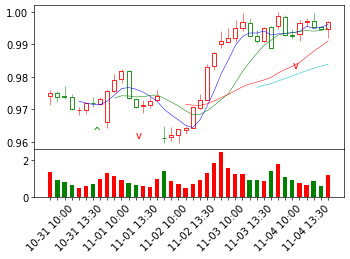

In [12]:
cs = Candlestick({'30m': [5,10,20, 30]}, n_plot_bars=40)
cs.plot_bars(shmin_10000[-40:], signals=signals)